In [1]:
import itertools
from pathlib import Path

import minisom
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import shapely

from plotly.colors import sample_colorscale, DEFAULT_PLOTLY_COLORS
from plotly.subplots import make_subplots
from plotly.figure_factory import create_dendrogram
from scipy.cluster import hierarchy
from sklearn.metrics import davies_bouldin_score
from IPython.display import IFrame, Image

In [2]:
# Parameters
data_path = Path(r'data.csv')
input_columns = ['pH', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'Cl', 'SO4']

som_nx = 7
som_ny = 7
som_sigma = 1.5
som_learning_rate = 0.7
som_activation_distance = 'euclidean'
som_topology = 'hexagonal'
som_neighborhood_function = 'gaussian'
som_random_seed = 10
som_max_iterations = 3000

max_clusters = 10
number_of_clusters = 4  # Set to None to pick the optimal number automatically

# Visualization
pio.templates.default = 'plotly_white'
plotly_interactive = False

In [3]:
# Convenience function to allow changing between interactive and static images
# Needed to show figures on GitHub notebook preview
def show_figure(fig: go.Figure):
    global fig_count
    if plotly_interactive:
        return fig
    else:
        return Image(data=fig.to_image(format='png', scale=2))


In [4]:
# Read input data
df = pd.read_csv(data_path)
df.describe()

,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
count,102.0,102.0,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.000000
mean,0.6,30.0,7.680392,7.710784,12.067647,18.490196,2.057843,10.184314,0.0,8.826471,17.335294,2627.794118
std,0.0,0.0,0.214356,6.420371,6.753762,11.158325,1.243553,3.368454,0.0,10.335902,12.658083,1313.058242
min,0.6,30.0,6.300000,0.400000,1.200000,0.200000,0.000000,2.500000,0.0,1.000000,2.000000,856.000000
25%,0.6,30.0,7.600000,3.650000,8.000000,11.825000,1.300000,8.500000,0.0,4.400000,9.025000,1902.000000
50%,0.6,30.0,7.700000,6.600000,11.300000,16.050000,1.800000,10.350000,0.0,7.300000,13.800000,2452.000000
75%,0.6,30.0,7.800000,9.550000,15.000000,21.950000,2.400000,12.775000,0.0,9.750000,23.500000,2981.000000
max,0.6,30.0,8.400000,42.600000,58.400000,81.300000,9.000000,16.800000,0.0,78.000000,66.300000,9629.000000


In [5]:
# Extend with auxiliary data
ions_WEIGHT = {
    'Ca'  : 40.0780,
    'Mg'  : 24.3050,
    'K'   : 39.0983,
    'Na'  : 22.9898,
    'Cl'  : 35.4527,
    'SO4' : 96.0636,
    'CO3' : 60.0092,
    'HCO3': 61.0171
}

ions_CHARGE = {
    'Ca'  : +2,
    'Mg'  : +2,
    'K'   : +1, 
    'Na'  : +1,
    'Cl'  : -1,
    'SO4' : -2,
    'CO3' : -2,
    'HCO3': -1,
}

for column in df.columns:
    if column in ions_WEIGHT:
        df[f'{column}_meq/L'] = df[column] / ions_WEIGHT[column] * abs(ions_CHARGE[column])

sum_cations = df[['Ca_meq/L', 'Mg_meq/L', 'K_meq/L', 'Na_meq/L']].sum(axis=1)
sum_anions = df[['Cl_meq/L', 'SO4_meq/L', 'CO3_meq/L', 'HCO3_meq/L']].sum(axis=1)

df['Ca%'] = df['Ca_meq/L'] / sum_cations
df['Mg%'] = df['Mg_meq/L'] / sum_cations
df['K+Na%'] = (df['K_meq/L'] + df['Na_meq/L']) / sum_cations

df['Cl%'] = df['Cl_meq/L'] / sum_anions
df['SO4%'] = df['SO4_meq/L'] / sum_anions
df['CO3+HCO3%'] = (df['CO3_meq/L'] + df['HCO3_meq/L']) / sum_anions


In [6]:
df

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,...,HCO3_meq/L,CO3_meq/L,Cl_meq/L,SO4_meq/L,Ca%,Mg%,K+Na%,Cl%,SO4%,CO3+HCO3%
0,sample1,K-1,red,o,0.6,30,7.5,3.2,7.1,11.5,...,0.242555,0.0,0.062055,0.072868,0.125010,0.457367,0.417622,0.164392,0.193040,0.642567
1,sample2,K-1,red,o,0.6,30,7.7,2.6,7.0,13.0,...,0.217972,0.0,0.107185,0.066623,0.099268,0.440702,0.460030,0.273585,0.170051,0.556363
2,sample3,K-1,red,o,0.6,30,7.3,1.2,8.0,12.0,...,0.227805,0.0,0.056413,0.070786,0.047026,0.516961,0.436013,0.158908,0.199396,0.641696
3,sample4,K-1,red,o,0.6,30,7.4,2.2,6.6,12.6,...,0.222888,0.0,0.067696,0.064541,0.088769,0.439130,0.472101,0.190625,0.181741,0.627634
4,sample5,K-1,red,o,0.6,30,7.3,2.5,9.6,10.3,...,0.234361,0.0,0.056413,0.070786,0.089696,0.567959,0.342345,0.156027,0.195781,0.648192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,sample98,P-7,orange,o,0.6,30,7.9,1.8,2.4,3.8,...,0.065555,0.0,0.028207,0.070786,0.194075,0.426696,0.379230,0.171418,0.430186,0.398396
98,sample99,P-8,cyan,o,0.6,30,7.5,12.2,14.0,8.6,...,0.090139,0.0,0.169240,0.487177,0.281793,0.533223,0.184983,0.226694,0.652567,0.120739
99,sample100,P-8,cyan,o,0.6,30,7.8,12.8,13.4,9.6,...,0.103250,0.0,0.169240,0.495505,0.292053,0.504158,0.203789,0.220366,0.645194,0.134441
100,sample101,P-8,cyan,o,0.6,30,7.8,11.6,12.0,11.4,...,0.085222,0.0,0.174881,0.495505,0.276252,0.471237,0.252511,0.231444,0.655770,0.112786


In [7]:
# Derive SOM dimensions
if som_nx is None or som_ny is None:
    som_m = 5 * np.sqrt(len(df))
    som_nx = np.round(np.sqrt(som_m)).astype(int)
    som_ny = np.round(som_m / som_nx).astype(int)

print(f"SOM dimensions: {som_nx} x {som_ny}")

SOM dimensions: 7 x 7


In [8]:
# Train the SOM model

# Set up data transform for input
input_array = df[input_columns].values

# Normalization:
# norm_b = input_array.min(axis=0)
# norm_a = input_array.max(axis=0) - norm_b

# Standardization
norm_b = input_array.mean(axis=0)
norm_a = input_array.std(axis=0)

data_transform = lambda x: (x - norm_b) / norm_a
inverse_data_transform = lambda y: norm_a * y + norm_b

# Set up model
som = minisom.MiniSom(
    som_nx,
    som_ny,
    len(input_columns),
    sigma=som_sigma,
    learning_rate=som_learning_rate,
    activation_distance=som_activation_distance,
    topology=som_topology,
    neighborhood_function=som_neighborhood_function,
    random_seed=som_random_seed,
)

# Train
som.train(data_transform(input_array), som_max_iterations)

# Extract data
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()
win_map = som.win_map(data_transform(df[input_columns].values), return_indices=True)

In [9]:
# Create hexagons for visualization
def hexagon(_xx, _yy, radius):
    # Returns a NX x NY x 6 x 2 array of hexagon coordinates
    hex_xy = np.zeros((_xx.shape[0], _xx.shape[1], 7, 2))
    for i in range(7):
        theta = np.pi / 6 + 2 * np.pi * i / 6
        hex_xy[:, :, i, 0] = _xx + radius * np.cos(theta)
        hex_xy[:, :, i, 1] = _yy + radius * np.sin(theta)
    return hex_xy


hexagons = hexagon(xx, yy, 0.5)
hexagons.shape

(7, 7, 7, 2)

In [10]:
# Setup input to clustering and dendrogram plot
mij = np.meshgrid(np.arange(som_nx), np.arange(som_ny), indexing='ij')
cells_ij = np.column_stack((mij[0].flat, mij[1].flat))
labels = [(i, j) for i, j in cells_ij]
flat_weights = weights.reshape(-1, len(input_columns)) 

links = hierarchy.linkage(flat_weights, method='complete', metric='euclidean')


In [11]:
cluster_results = []

for i in range(2, max_clusters):
    flat_labels = hierarchy.fcluster(links, i, 'maxclust')
    dbi = davies_bouldin_score(flat_weights, flat_labels) if len(set(flat_labels)) == i else None
    cluster_results.append(dict(
        n_clusters=i,
        dbi=dbi,
        labels=flat_labels
    ))

cluster_df = pd.DataFrame.from_dict(cluster_results)
optimal_cluster = cluster_df.iloc[cluster_df['dbi'].idxmin()]
if number_of_clusters is None:
    selected_cluster = optimal_cluster
else:
    selected_cluster = cluster_df[cluster_df['n_clusters'] == number_of_clusters].iloc[0]

In [12]:
fig = px.line(cluster_df, x='n_clusters', y='dbi', markers=True)
fig.layout.title = f"Optimal number of clusters: {optimal_cluster['n_clusters']}"
fig

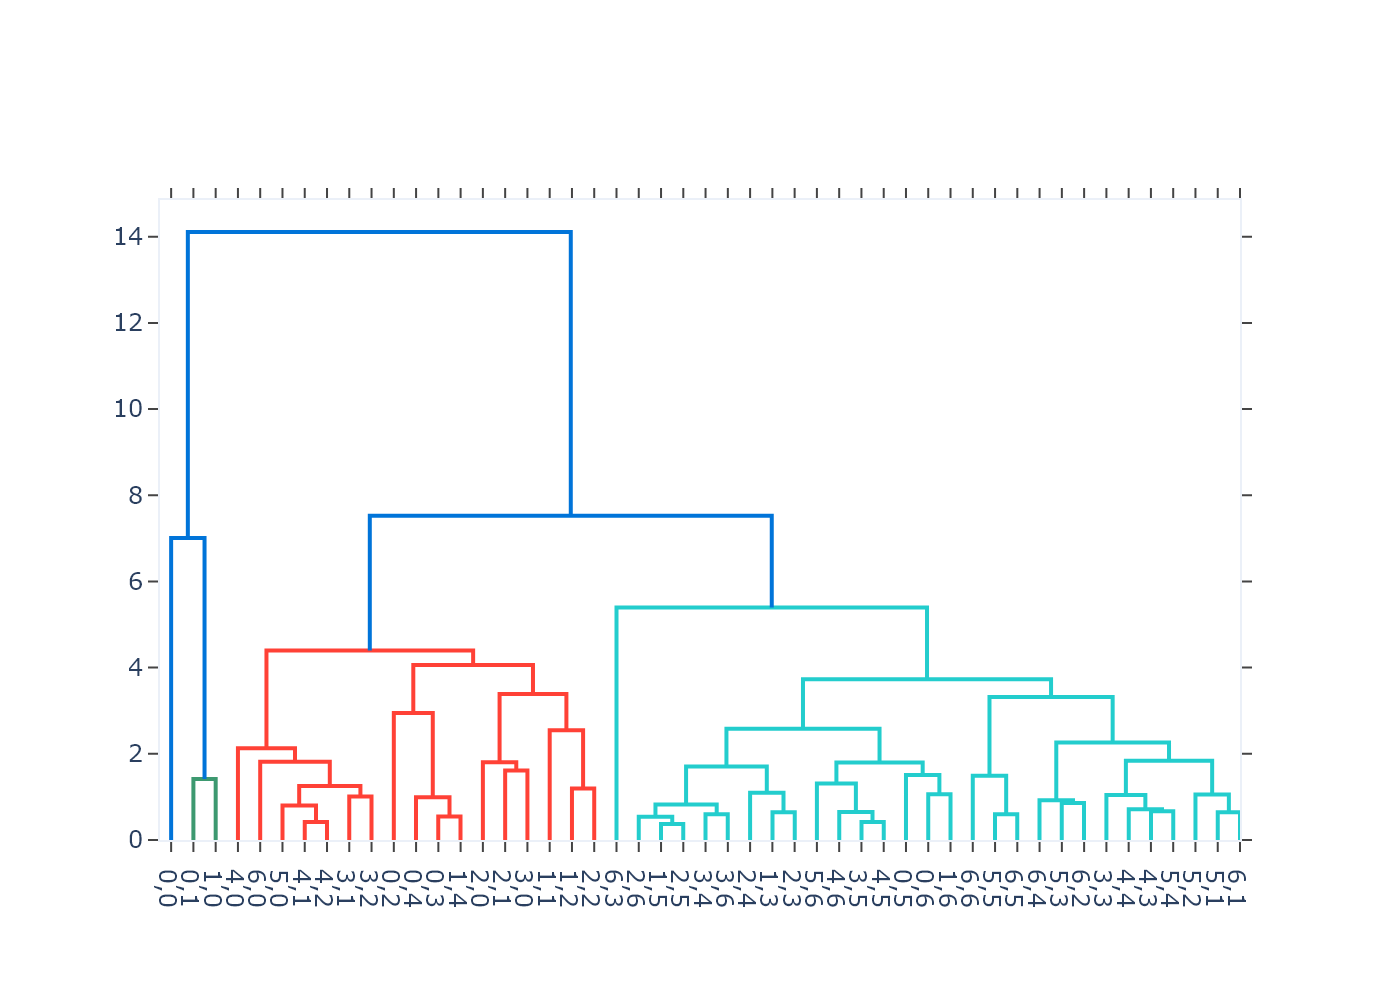

In [13]:
# Using method 'complete' in scipy's linkage function yields the same as the default in create_dendrogram
show_figure(create_dendrogram(
    flat_weights,
    linkagefun=lambda _: links,
    labels=labels,
    # NB! The color_threshold must be manually set to a value corresponding to the number of clusters
    color_threshold=6
))

In [14]:
# Optimal number of lables
node_labels = selected_cluster['labels'].reshape(som_nx, som_ny)

# Sample labels
sample_ij = [None] * len(df)
sample_label = [-1] * len(df)
for key, value in win_map.items():
    for ix in value:
        sample_ij[ix] = key
        sample_label[ix] = node_labels[key]

df['ij'] = sample_ij
df['cluster_label'] = sample_label

# Cluster polygons
node_hexagons = hexagon(xx, yy, np.sqrt(3) / 3 + 0.001).reshape(-1, 7, 2)
cluster_boundaries = {}
for c in np.unique(node_labels):
    matches = node_labels.flatten() == c
    joined_polygon = shapely.union_all([shapely.Polygon(p) for p in node_hexagons[matches]])
    cluster_boundaries[c] = joined_polygon

# Plotting and Visualization

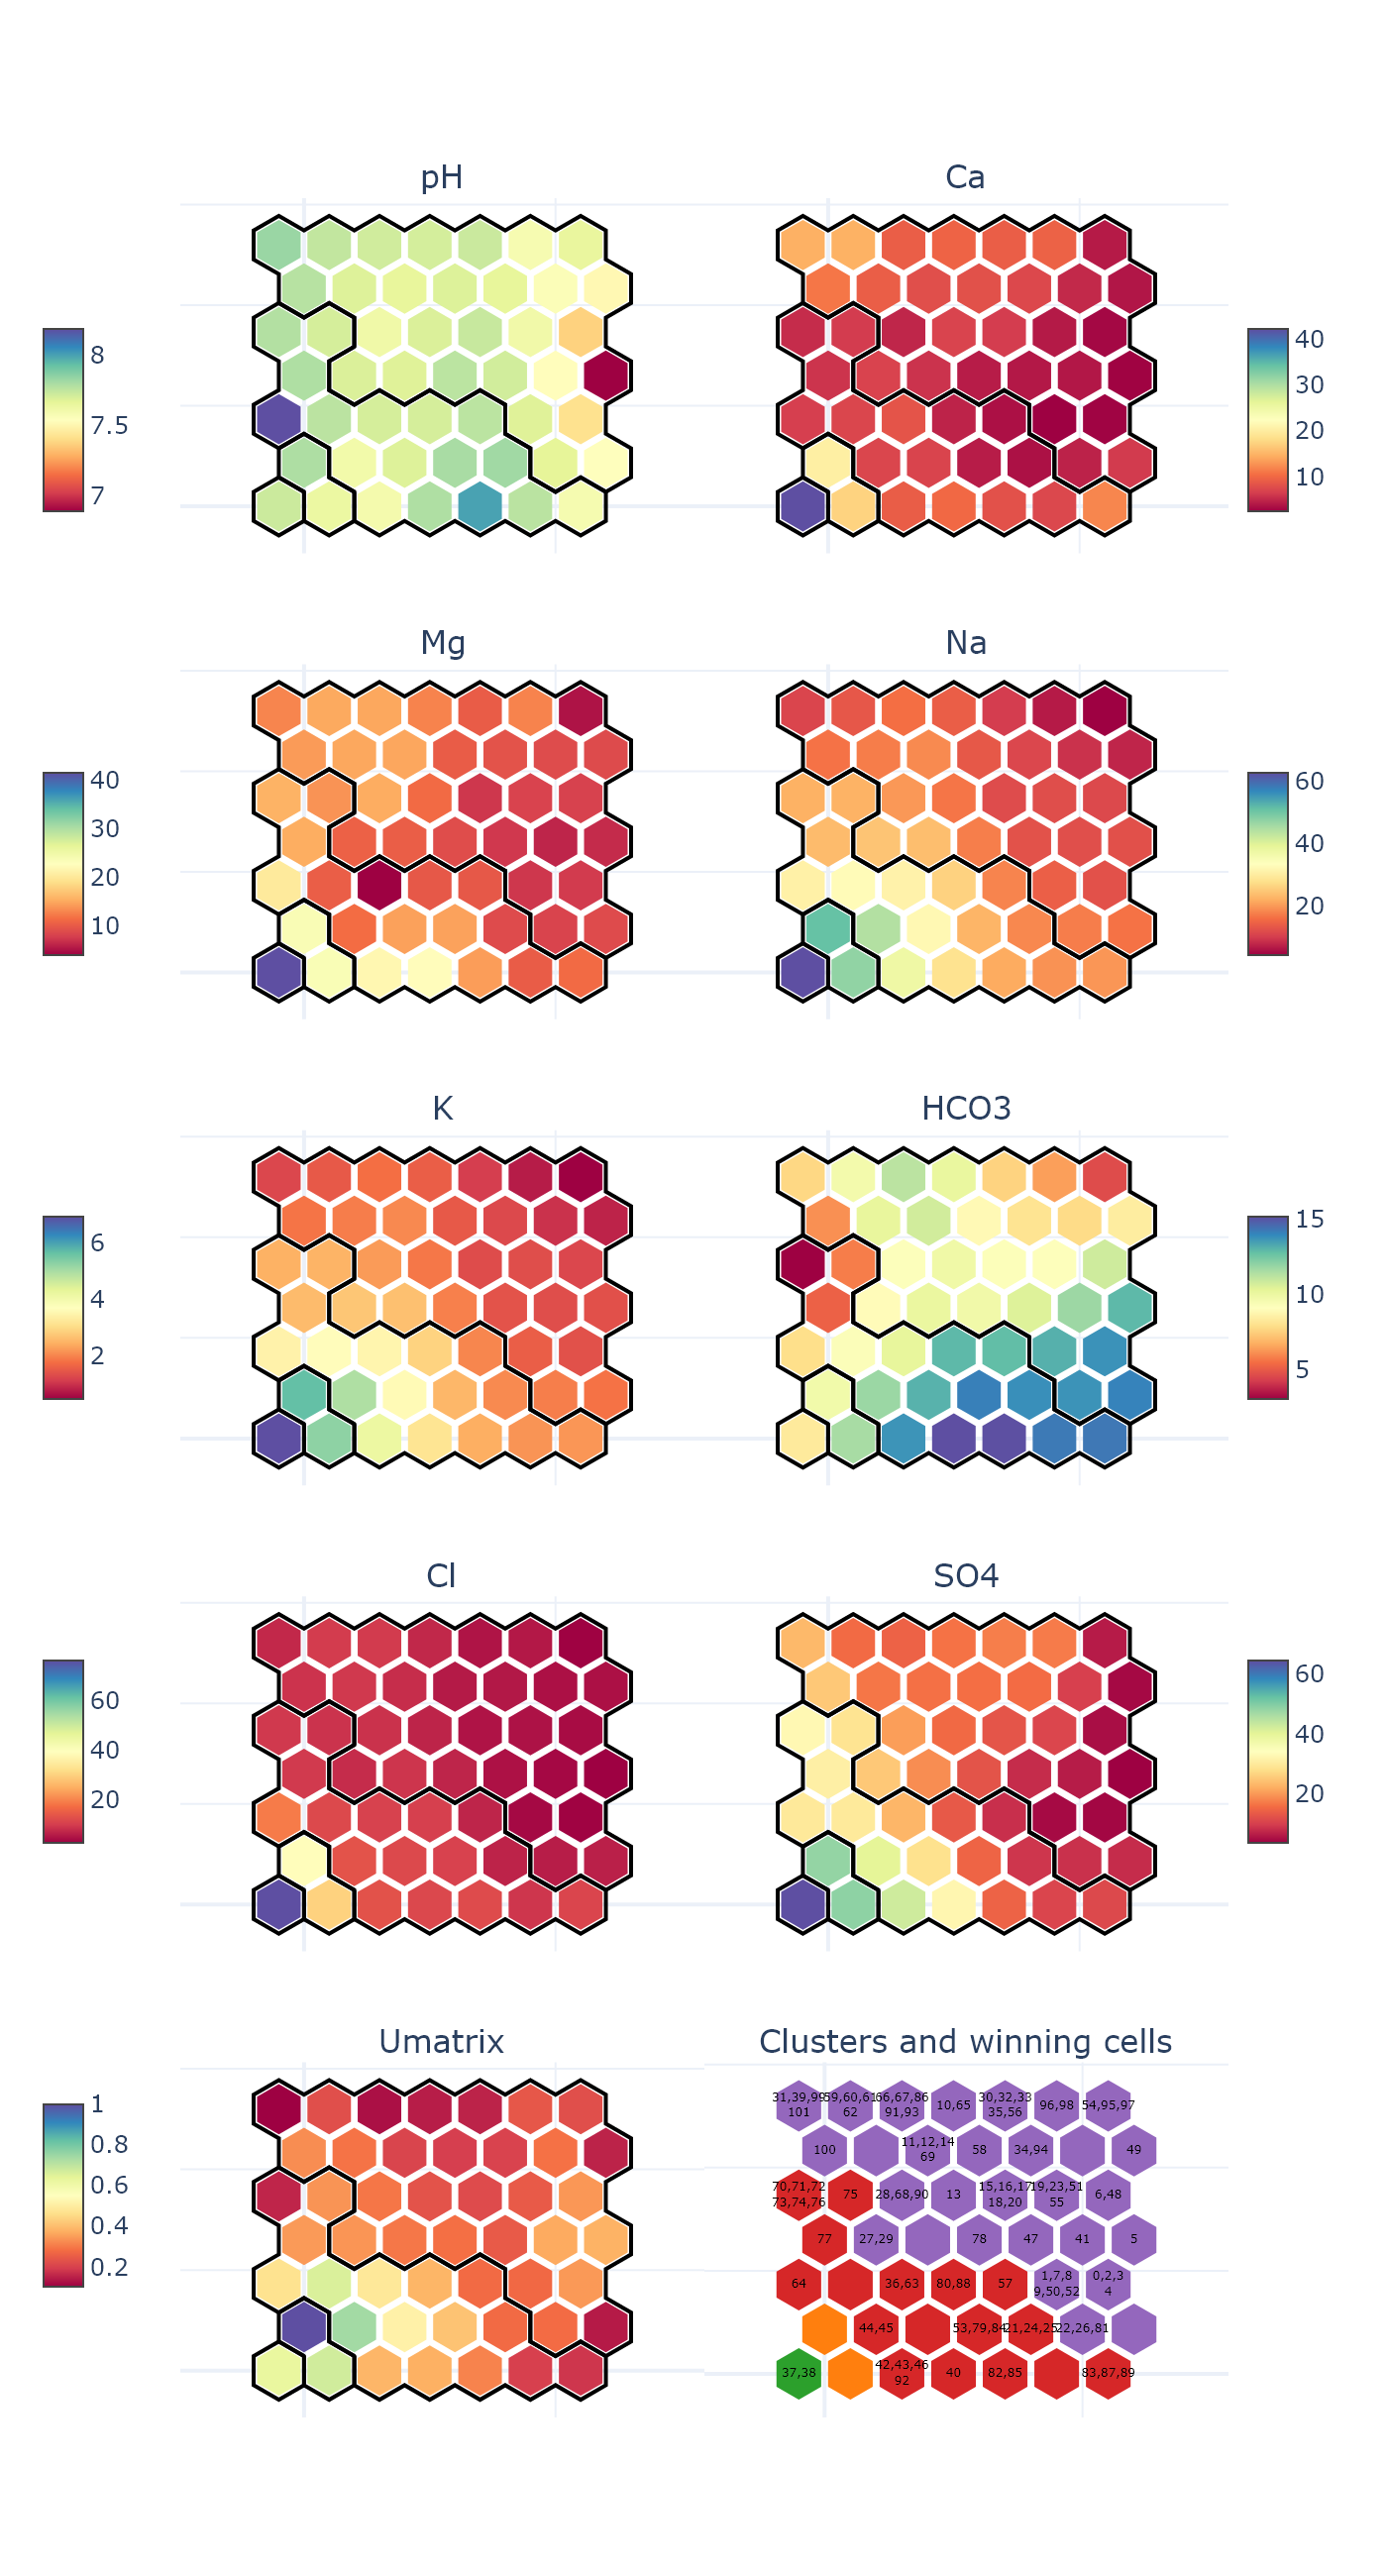

In [15]:
# Define functions for plotting
def add_cluster_boundaries(fig: go.Figure, row_index, col_index):
    for k, boundary in cluster_boundaries.items():
        
        if boundary.geom_type == 'Polygon':
            bnds = [boundary]
        elif boundary.geom_type == 'MultiPolygon':
            bnds = list(boundary.geoms)
        else:
            raise NotImplementedError(boundary.geom_type)
        
        for poly in bnds:
            if poly.boundary.geom_type == 'LineString':
                crds = np.array(poly.boundary.coords)
            else:
                crds = np.array(poly.boundary.geoms[0].coords)

            fig.add_scatter(
                x=crds[:, 0],
                y=crds[:, 1],
                # fill='toself',
                mode="lines",
                showlegend=False,
                line=dict(color='black', width=2),
                row=row_index,
                col=col_index,
            )


def add_som_features(fig: go.Figure, row, col, feature_index, colorbar_settings):
    if feature_index >= weights.shape[2]:
        w = umatrix.copy()
    else:
        w = inverse_data_transform(weights)[:, :, feature_index]

    w_min = w.min()
    w_max = w.max()
    w -= w.min()
    w /= w.max()
    colors = np.array(
        sample_colorscale('spectral', w.flatten())
    ).reshape(som_nx, som_ny)

    # Add colored hexagons
    for i in range(som_nx):
        for j in range(som_ny):
            text = str(sorted(df.iloc[win_map[(i, j)]].index.values.tolist()))

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=colors[i, j],
                line=dict(color='black', width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )
           
    fig.add_scatter(
        x=[0, 0],
        y=[0, 0],
        showlegend=False,
        marker=dict(color=[w_min, w_max], colorscale="spectral", size=0.001, colorbar=colorbar_settings),
        row=row,
        col=col,
    )


def add_training_cells(fig: go.Figure, row, col):
    # Add colored hexagons
    label_colors = DEFAULT_PLOTLY_COLORS
    for i in range(som_nx):
        for j in range(som_ny):
            text = ""
            if len(win_map[(i, j)]) > 0:
                samples = [str(s) for s in sorted(df.iloc[win_map[(i, j)]].index.values.tolist())]
                if len(samples) <= 3:
                    text = f"{','.join(samples)}"
                elif len(samples) <= 6:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:])}"
                elif len(samples) <= 9:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:6])}" + f"<br>{','.join(samples[6:])}"
                else:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:-3])}" + f"<br>{','.join(samples[-3:])}"

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=label_colors[node_labels[i, j]],
                line=dict(width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )

            mid = (hexagons[i, j, 0, :] + hexagons[i, j, 3, :]) / 2
            fig.add_scatter(
                x=[mid[0]],
                y=[mid[1]],
                mode="text",
                text=text,
                textfont=dict(color="black", size=6),
                marker=dict(color='black'),
                showlegend=False,
                hoverinfo="none",
                row=row,
                col=col,
            )


n_plots = len(input_columns) + 2
subplot_rows = (n_plots + 1) // 2
subplot_columns = 2
features_fig = make_subplots(
    rows=subplot_rows,
    cols=subplot_columns,
    subplot_titles=input_columns + ["Umatrix"] + ["Clusters and winning cells"],
    horizontal_spacing=0,
    vertical_spacing=0.05,

)
features_fig.layout.height = 50 + 250 * subplot_rows

subplot_ix = list(
    itertools.product(range(1, subplot_rows + 1), range(1, subplot_columns + 1))
)[:n_plots]

# Feature plots
for i, (row_index, col_index) in enumerate(subplot_ix[:len(input_columns)+1]):
    add_cluster_boundaries(features_fig, row_index, col_index)
    colorbar_settings = dict(
        thickness = 20,
        len = 0.5 * (1 / subplot_rows),
        y = 1 - (row_index - 0.5) / subplot_rows,
        x = -0.15 if col_index == 1 else 1
    )
    add_som_features(features_fig, row_index, col_index, i, colorbar_settings)

add_training_cells(features_fig, subplot_ix[-1][0], subplot_ix[-1][1])


for i, (row_index, col_index) in enumerate(subplot_ix):
    sp = features_fig.get_subplot(row_index, col_index)
    sp.yaxis.scaleanchor = sp.yaxis.anchor
    sp.yaxis.showticklabels = False
    sp.xaxis.showticklabels = False


show_figure(features_fig)

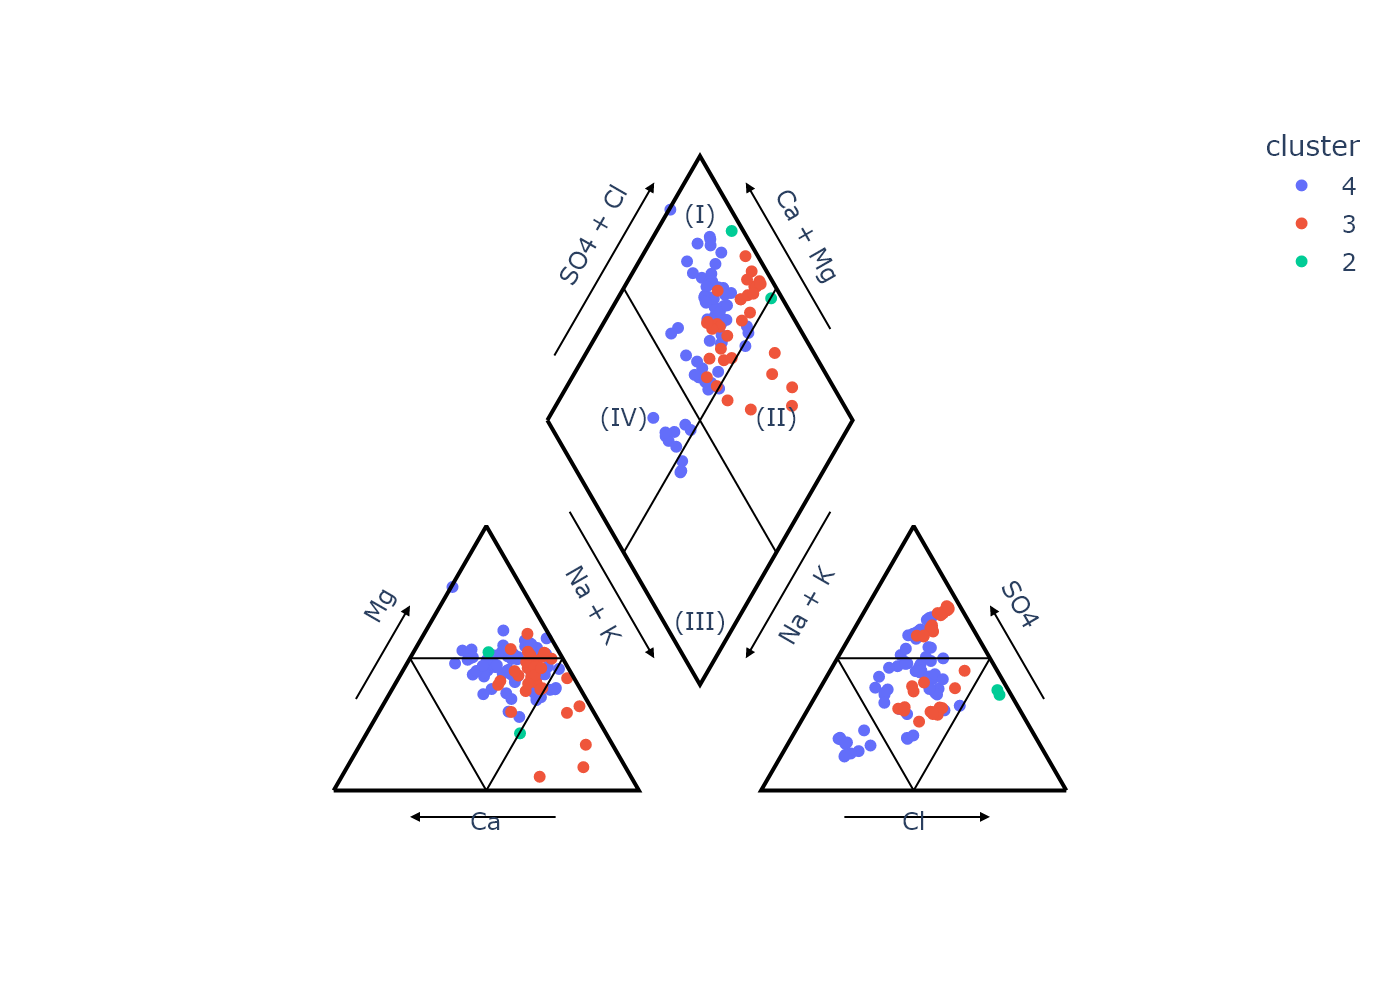

In [16]:
# ------------------------------------------------------------
# Figure settings
# ------------------------------------------------------------

axis_length = 10
theta = np.pi/3
line_color = "black"
gap = 0.4
arrow_args = dict(
    axref="x",
    ayref="y",
    showarrow=True,
    arrowhead=2,
    arrowcolor=line_color,
)
arrow_txt_args = dict(
    showarrow=False,
)
outer_axis_args = dict(
    mode="lines",
    line=dict(color=line_color, width=2),
    showlegend=False,
)
inner_axis_args = dict(
    mode="lines",
    line=dict(color=line_color, width=1),
    showlegend=False,
)

diamond_u = axis_length * np.array([np.cos(-theta), np.sin(-theta)])
diamond_v = axis_length * np.array([np.cos(theta), np.sin(theta)])

lowerleft_v = diamond_v.copy()
lowerleft_u = np.array([axis_length, 0])
lowerleft_w = -diamond_u
lowerleft_o = np.zeros_like(lowerleft_v)

diamond_o = lowerleft_o + (1 + gap) * diamond_v
lowerright_o = lowerleft_o + (2 + gap)  * diamond_v + (2 + gap) * diamond_u
lowerright_u = -lowerleft_u
lowerright_v = -diamond_u
lowerright_w = lowerleft_v

# ------------------------------------------------------------
# Setup data and initial plot
# ------------------------------------------------------------

# Lower left data
data_lowerleft = (
    lowerleft_o[:, np.newaxis]
    + (1 - (df['Ca%'])).values * lowerleft_u[:, np.newaxis]
    + df['Mg%'].values * lowerleft_w[:, np.newaxis]
).T

# Lower right data
data_lowerright = (
    lowerright_o[:, np.newaxis]
    + (1 - (df['Cl%'])).values * lowerright_u[:, np.newaxis]
    + df['SO4%'].values * lowerright_w[:, np.newaxis]
).T

# Diamond data
data_diamond = (
    diamond_o[:, np.newaxis]
    + df['K+Na%'].values * diamond_u[:, np.newaxis]
    + (df['SO4%'] + df['Cl%']).values * diamond_v[:, np.newaxis]
).T

xy_data = np.vstack((data_lowerleft, data_lowerright, data_diamond))
plotting_df = pd.DataFrame(xy_data, columns=['x', 'y'])
plotting_df['cluster'] = np.hstack([df['cluster_label'].values.tolist()] * 3).astype(str)
fig_piper = px.scatter(plotting_df, x="x", y="y", color="cluster")

# ------------------------------------------------------------
# Lower-left triangle
# ------------------------------------------------------------

ll_axis = np.array([
    lowerleft_o,
    lowerleft_o + lowerleft_v,
    lowerleft_o + lowerleft_u,
    lowerleft_o,
])
fig_piper.add_scatter(
    x=ll_axis[:, 0],
    y=ll_axis[:, 1],
    **outer_axis_args,
)
ll_tri = np.array([
    lowerleft_o + 0.5 * lowerleft_u,
    lowerleft_o + 0.5 * lowerleft_u + 0.5 * lowerleft_v,
    lowerleft_o + 0.5 * lowerleft_v,
    lowerleft_o + 0.5 * lowerleft_u,
])
fig_piper.add_scatter(
    x=ll_tri[:, 0],
    y=ll_tri[:, 1],
    **inner_axis_args,
)
lowerleft_arrows = np.array([
    # Mg
    lowerleft_o - 0.1 * lowerleft_u + 0.3 * lowerleft_v,
    lowerleft_o - 0.1 * lowerleft_u + 0.7 * lowerleft_v,
    # Ca
    lowerleft_o + 0.8 * lowerleft_u - 0.1 * lowerleft_v,
    lowerleft_o + 0.3 * lowerleft_u - 0.1 * lowerleft_v,
])
fig_piper.add_annotation(
    x=lowerleft_arrows[1, 0],
    y=lowerleft_arrows[1, 1],
    ax=lowerleft_arrows[0, 0],
    ay=lowerleft_arrows[0, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerleft_arrows[3, 0],
    y=lowerleft_arrows[3, 1],
    ax=lowerleft_arrows[2, 0],
    ay=lowerleft_arrows[2, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerleft_o[0] + 0.5 * lowerleft_u[0],
    y=lowerleft_o[1] - 0.1 * axis_length,
    text="Ca",
    showarrow=False,
)
arrow_text_mg = lowerleft_o - 0.2 * lowerleft_u + 0.7 * lowerleft_v 
fig_piper.add_annotation(
    x=arrow_text_mg[0],
    y=arrow_text_mg[1],
    text="Mg",
    textangle=-60,
    showarrow=False,
)

# ------------------------------------------------------------
# Lower right triangle
# ------------------------------------------------------------

lr_axis = np.array([
    lowerright_o,
    lowerright_o + lowerright_v,
    lowerright_o + lowerright_u,
    lowerright_o,
])
fig_piper.add_scatter(
    x=lr_axis[:, 0],
    y=lr_axis[:, 1],
    **outer_axis_args,
)
lr_tri = np.array([
    lowerright_o + 0.5 * lowerright_u,
    lowerright_o + 0.5 * lowerright_u + 0.5 * lowerright_v,
    lowerright_o + 0.5 * lowerright_v,
    lowerright_o + 0.5 * lowerright_u,
])
fig_piper.add_scatter(
    x=lr_tri[:, 0],
    y=lr_tri[:, 1],
    **inner_axis_args,
)
lowerright_arrows = np.array([
    # Mg
    lowerright_o - 0.1 * lowerright_u + 0.3 * lowerright_v,
    lowerright_o - 0.1 * lowerright_u + 0.7 * lowerright_v,
    # Ca
    lowerright_o + 0.8 * lowerright_u - 0.1 * lowerright_v,
    lowerright_o + 0.3 * lowerright_u - 0.1 * lowerright_v,
])
fig_piper.add_annotation(
    x=lowerright_arrows[1, 0],
    y=lowerright_arrows[1, 1],
    ax=lowerright_arrows[0, 0],
    ay=lowerright_arrows[0, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerright_arrows[3, 0],
    y=lowerright_arrows[3, 1],
    ax=lowerright_arrows[2, 0],
    ay=lowerright_arrows[2, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerright_o[0] + 0.5 * lowerright_u[0],
    y=lowerright_o[1] - 0.1 * axis_length,
    text="Cl",
    showarrow=False,
)
arrow_text_so4 = lowerright_o - 0.2 * lowerright_u + 0.7 * lowerright_v 
fig_piper.add_annotation(
    x=arrow_text_so4[0],
    y=arrow_text_so4[1],
    text="SO4",
    textangle=60,
    showarrow=False,
)

# ------------------------------------------------------------
# Diamond axis parameters
# ------------------------------------------------------------

# Diamond axes
axis_xy = np.array([
    diamond_o,
    diamond_o + diamond_v,
    diamond_o + diamond_v + diamond_u,
    diamond_o + diamond_u,
    diamond_o,
])
fig_piper.add_scatter(
    x=axis_xy[:, 0],
    y=axis_xy[:, 1],
    **outer_axis_args,
)

# Diamond Cross
cross_xy = np.array([
    diamond_o + 0.5 * diamond_u,
    diamond_o + 0.5 * diamond_u + diamond_v,
    [None, None],
    diamond_o + 0.5 * diamond_v,
    diamond_o + 0.5 * diamond_v + diamond_u
])
fig_piper.add_scatter(
    x=cross_xy[:, 0],
    y=cross_xy[:, 1],
    **inner_axis_args,    
)

# Diamond roman text
romans_xy = np.array([
    diamond_o + diamond_v - np.array([0, 0.2 * axis_length]),
    diamond_o + np.array([0.75 * axis_length, 0]),
    diamond_o + diamond_u + np.array([0, 0.2 * axis_length]),
    diamond_o + np.array([0.25 * axis_length, 0]),
])
fig_piper.add_scatter(
    x=romans_xy[:, 0],
    y=romans_xy[:, 1],
    text=["(I)", "(II)", "(III)", "(IV)"],
    mode="text",
    showlegend=False,
)

# Diamond arrows and text
arrows = np.array([
    # SO4 + Cl
    diamond_o + -0.1 * diamond_u + 0.1 * diamond_v,
    diamond_o + -0.1 * diamond_u + 0.8 * diamond_v,
    # Ca + Mg
    diamond_o + 1.1 * diamond_v + 0.8 * diamond_u,
    diamond_o + 1.1 * diamond_v + 0.2 * diamond_u,
    # Na + K
    diamond_o + -0.1 * diamond_v + 0.2 * diamond_u,
    diamond_o + -0.1 * diamond_v + 0.8 * diamond_u,
    # HCO3 + CO3
    diamond_o + 1.1 * diamond_u + 0.8 * diamond_v,
    diamond_o + 1.1 * diamond_u + 0.2 * diamond_v,
])
for i in range(0, 8, 2):
    fig_piper.add_annotation(
        x=arrows[i + 1, 0],
        y=arrows[i + 1, 1],
        ax=arrows[i, 0],
        ay=arrows[i, 1],
        **arrow_args
    )
    
arrow_txt1 = diamond_o + -0.2 * diamond_u + 0.5 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt1[0],
    y=arrow_txt1[1],
    text="SO4 + Cl",
    textangle=-60,
    **arrow_txt_args
)
arrow_txt2 = diamond_o + 0.5 * diamond_u + 1.2 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt2[0],
    y=arrow_txt2[1],
    text="Ca + Mg",
    textangle=60,
    **arrow_txt_args
)
arrow_txt3 = diamond_o + 0.5 * diamond_u - 0.2 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt3[0],
    y=arrow_txt3[1],
    text="Na + K",
    textangle=60,
    **arrow_txt_args
)
arrow_txt4 = diamond_o + 1.2 * diamond_u + 0.5 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt4[0],
    y=arrow_txt4[1],
    text="Na + K",
    textangle=-60,
    **arrow_txt_args
)

# ------------------------------------------------------------
# Final layout adjustments
# ------------------------------------------------------------
fig_piper.layout.yaxis.scaleanchor = 'x'
fig_piper.layout.xaxis.showgrid = False
fig_piper.layout.xaxis.zeroline = False
fig_piper.layout.xaxis.showticklabels = False
fig_piper.layout.xaxis.title = None
fig_piper.layout.yaxis.showgrid = False
fig_piper.layout.yaxis.zeroline = False
fig_piper.layout.yaxis.showticklabels = False
fig_piper.layout.yaxis.title = None

show_figure(fig_piper)


# TODO:

- ✅ Remove test-train split. Can re-introduce later if we consider it relevant
- ✅ Cluster count analysis. Refer to other sources/papers for common techniques. Include relevant plots
- ⬜ Clustering on HCA results or log-standardized input?
- ✅ Hexagonal cluster plot with correct colors
- ⬜ Piper diagram:
  - ⬜ Sync colors in piper diagram with dendrogram
  - ⬜ Axis ticks
  - ⬜ Legend with roman numerals and "water type"
  - ⬜ Sort legend by cluster
- ⬜ Gibbs diagram
